In [1]:
import xarray as xr
import pandas as pd
import arviz as az
import bambi as bmb
import pymc as pm
import numpy as np
import graphviz as gv
import preliz as pz
import matplotlib.pyplot as plt

### Overview
To begin, an overview of my goals. I compiled data on Austin Water yearly consumption (per zipcode and usage class), Austin population, weather data, and gallons of water/wastewater treated. The goal is to figure out what factors impact yearly water consumption. I will be starting with using GLMs to analyze the data, and see if I can find any interesting interactions before looking at more complicated models.

In [2]:
data = pd.read_csv('proj7_data.csv').dropna()
data = data[(data['gallons'] >= 0) & (data['gallons'] < 25e6)]

data['zipcode_str'] = data['zipcode'].astype(str)
data

year  month  zipcode                      class     gallons  \
0      2012      1    78613    Irrigation - Commercial    855400.0   
1      2012      1    78613                 Commercial   2880800.0   
2      2012      1    78613  Irrigation - Multi-Family     11000.0   
3      2012      1    78613               Multi-Family     23000.0   
4      2012      1    78617             City of Austin   6500300.0   
...     ...    ...      ...                        ...         ...   
33736  2019      8    78759       Austin Water Utility       200.0   
33738  2019      8    78759    Irrigation - Commercial  21495100.0   
33740  2019      8    78759   Irrigation - Residential    218000.0   
33741  2019      8    78759  Irrigation - Multi-Family   3123600.0   
33743  2019      8    78738                Residential      1000.0   

         wastewater         water   temp_max   temp_min   humidity  \
0      6.364300e+09  6.017380e+09  66.025806  43.532258  63.570968   
1      6.364300e+09  6.017380e+09  66.025806  43.532258  63.570968   
2      6.364300e+09  6.017380e+09  66.025806  43.532258  63.570968   
3      6.364300e+09  6.017380e+09  66.025806  43.532258  63.570968   
4      6.364300e+09  6.017380e+09  66.025806  43.532258  63.570968   
...             ...           ...        ...        ...        ...   
33736  5.659080e+09  1.082946e+10  99.458065  77.722581  59.567742   
33738  5.659080e+09  1.082946e+10  99.458065  77.722581  59.567742   
33740  5.659080e+09  1.082946e+10  99.458065  77.722581  59.567742   
33741  5.659080e+09  1.082946e+10  99.458065  77.722581  59.567742   
33743  5.659080e+09  1.082946e+10  99.458065  77.722581  59.567742   

       precipitation  population zipcode_str  
0           0.167935      907161       78613  
1           0.167935      907161       78613  
2           0.167935      907161       78613  
3           0.167935      907161       78613  
4           0.167935      907161       78617  
...              ...         ...         ...  
33736       0.038516     1065502       78759  
33738       0.038516     1065502       78759  
33740       0.038516     1065502       78759  
33741       0.038516     1065502       78759  
33743       0.038516     1065502       78738  

[27568 rows x 13 columns]

### Causal Diagram
First I will create a causal diagram to help me understand the relationships between the variables. Since I hand-picked which variables to include through the ones I expect to have an impact, so they should mostly be pretty connected already. Let's take a look.

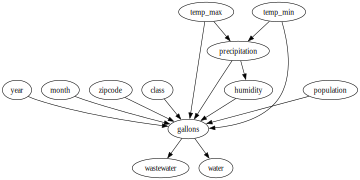

In [144]:
g = gv.Digraph(graph_attr={"size": "5,5!"})

for col in [c for c in data if c not in ['zipcode_str']]: g.node(col)

g.edge("temp_max", "precipitation")
g.edge("temp_min", "precipitation")
g.edge("precipitation", "humidity")

g.edge("year", "gallons")
g.edge("month", "gallons")
g.edge("class", "gallons")
g.edge("zipcode", "gallons")
g.edge("temp_max", "gallons")
g.edge("temp_min", "gallons")
g.edge("humidity", "gallons")
g.edge("precipitation", "gallons")
g.edge("population", "gallons")

g.edge("gallons", "water")
g.edge("gallons", "wastewater")

g

### First Model
As expected, Should be able to put pretty much all the variables into a model. Unfortunately gallons used likely affects the wastewater/water treated rather than the other way around, so we'll have to drop those. Let's just see how this does.

<Axes: xlabel='gallons'>

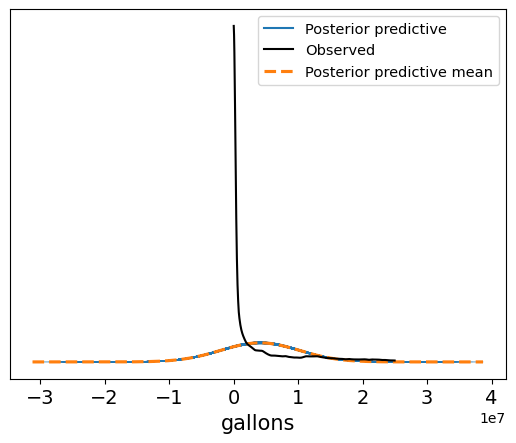

In [16]:
model_zip_cat.predict(model_zip_cat, kind="response")
az.plot_ppc(idata_zip_cat)

#### Predictions
One of the correlations I'm most curious about is how maximum temperature in a given month affects water consumption. Let's see what the model says.

/opt/homebrew/anaconda3/envs/data-science-fundamentals/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: temp_max
Default computed for unspecified variable: class, humidity, month, population, precipitation, temp_min, year


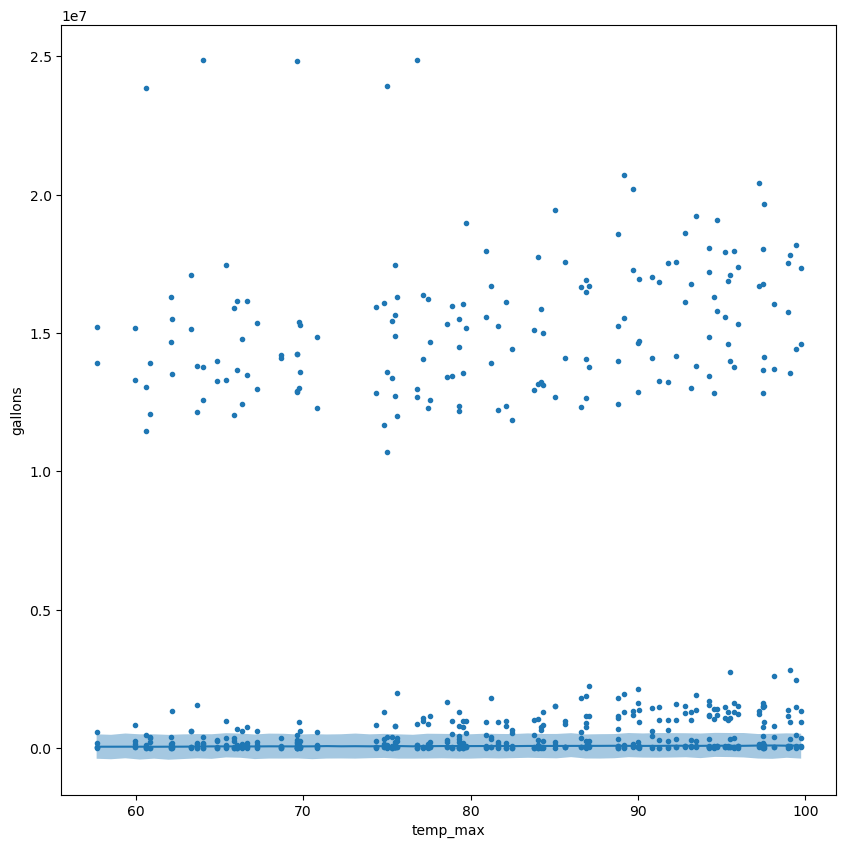

In [18]:
_, ax = bmb.interpret.plot_predictions(model_no_zip, idata_no_zip, ["temp_max"],
                                       pps = True,
                                       fig_kwargs={"figsize": (10, 10)})
zip = list(set(data['zipcode_str']))[2]
ax[0].plot(data["temp_max"][data['zipcode_str'] == zip], data["gallons"][data['zipcode_str'] == zip], ".")
# ax[0].plot(data["temp_max"], data["gallons"], "C2.")

### Analysis
Ok, a few things. The PPC doesn't look great, because it really isn't capturing the sharp rise around 0. Looking at the scatter plot, this makes a lot of sense. Probably should have checked that first. There is a strong break here, likely because we've got both commercial and residential data. I'll try a few different splits.

In [24]:
# looks like we should split. I'm gonna pick 1e6
model_below_1e6 = bmb.Model("gallons ~ temp_max + temp_min + humidity + precipitation + population + year + month + class + zipcode_str", data=data[data.gallons < 1e6])
idata_below_1e6 = model_below_1e6.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, temp_max, temp_min, humidity, precipitation, population, year, month, class, zipcode_str]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 258 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


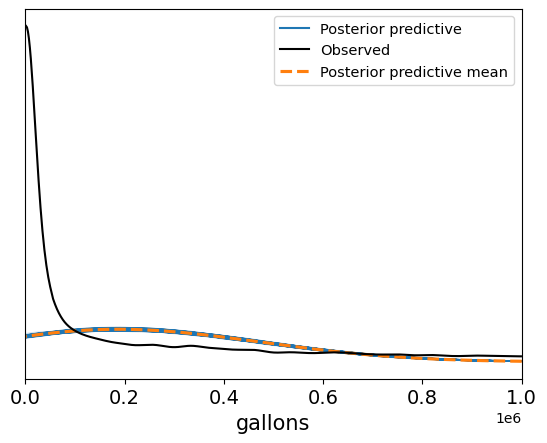

In [29]:
model_below_1e6.predict(idata_below_1e6, kind="response")
az.plot_ppc(idata_below_1e6).set_xbound(lower=0, upper=1e6)

/opt/homebrew/anaconda3/envs/data-science-fundamentals/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: temp_max, zipcode
Default computed for unspecified variable: class, humidity, month, population, precipitation, temp_min, year, zipcode_str


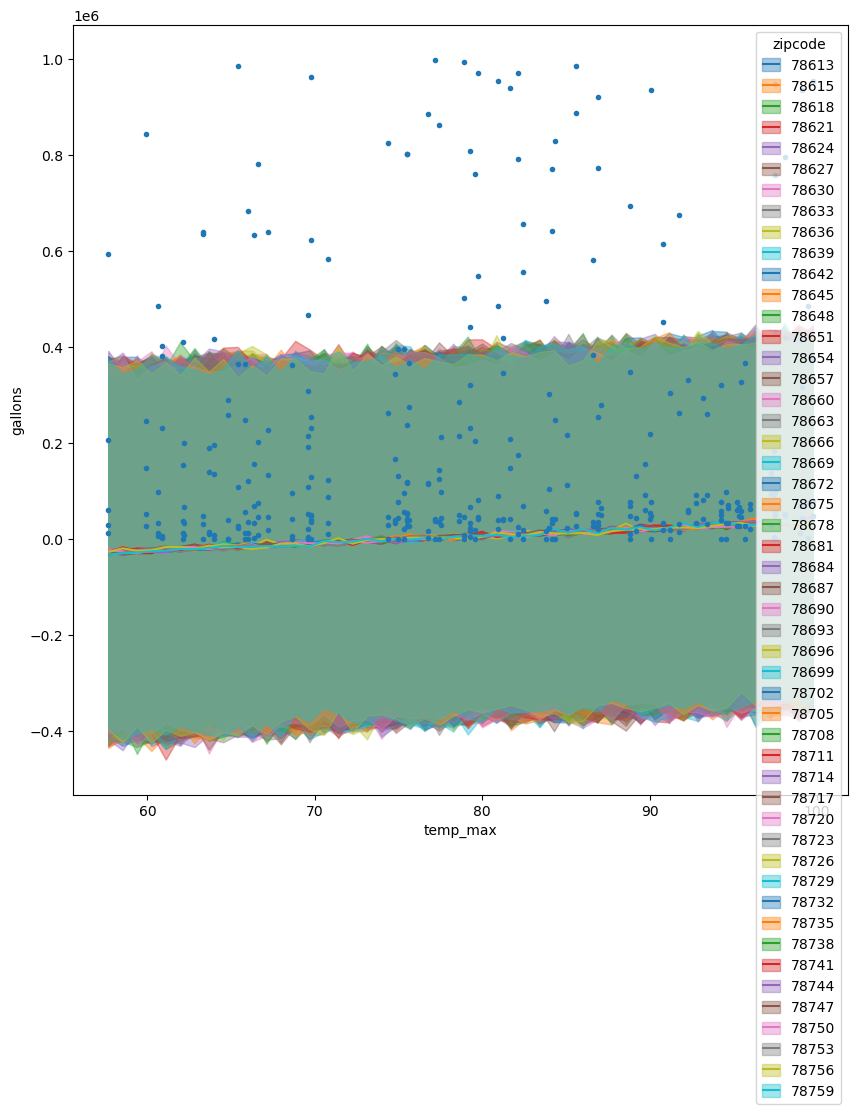

In [35]:
_, ax = bmb.interpret.plot_predictions(model_below_1e6, idata_below_1e6, ["temp_max", "zipcode"],
                                       pps = True,
                                       fig_kwargs={"figsize": (10, 10)})
zip = list(set(data['zipcode_str']))[2]
ax[0].plot(data["temp_max"][(data.gallons < 1e6) & (data.zipcode_str == zip)], data["gallons"][(data.gallons < 1e6) & (data.zipcode_str == zip)], ".")
# ax[0].plot(data["temp_max"], data["gallons"], "C2.")

In [46]:
model_below_1e5 = bmb.Model("gallons ~ temp_max + temp_min + humidity + precipitation + population + year + month + class + zipcode_str", data=data[data.gallons < 1e5])
idata_below_1e5 = model_below_1e5.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, temp_max, temp_min, humidity, precipitation, population, year, month, class, zipcode_str]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


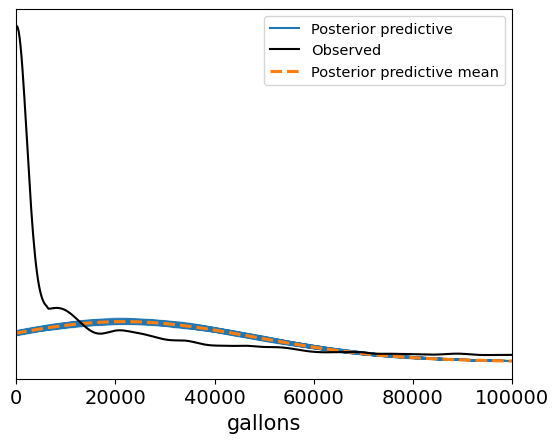

In [47]:
model_below_1e5.predict(idata_below_1e5, kind="response")
az.plot_ppc(idata_below_1e5).set_xbound(lower=0, upper=1e5)

### Analysis
Ok, largely the same result. I'm going to try paring it down to just predicting using `temp_max`, and try a couple more splits.

In [43]:
model_below_1e5_minimal = bmb.Model("gallons ~ temp_max", data=data[data.gallons < 1e5])
idata_below_1e5_minimal = model_below_1e5_minimal.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, temp_max]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


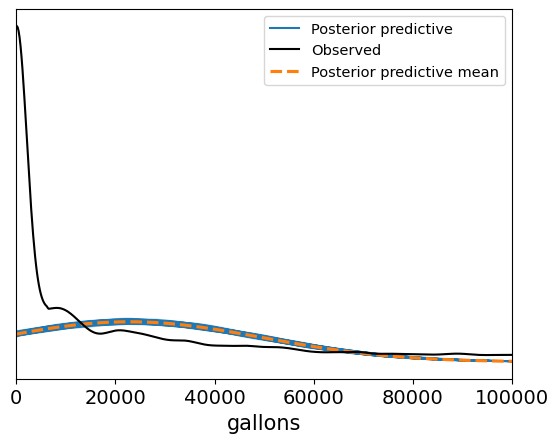

In [45]:
model_below_1e5_minimal.predict(idata_below_1e5_minimal, kind="response")
az.plot_ppc(idata_below_1e5_minimal).set_xbound(lower=0, upper=1e5)

In [56]:
model_below_1e4 = bmb.Model("gallons ~ temp_max", data=data[(data.gallons < 1e4) & (data.gallons > 0)])
idata_below_1e4 = model_below_1e4.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, temp_max]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


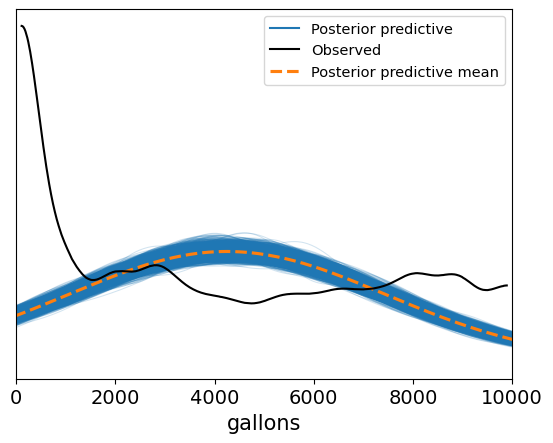

In [57]:
model_below_1e4.predict(idata_below_1e4, kind="response")
az.plot_ppc(idata_below_1e4).set_xbound(lower=0, upper=1e4)

### Analysis
Ok still largely the same. I really should have realized this several models ago, but I'm going to try taking out the zeroes. That should lower the peak on the left and make the model a little happier. I'll try going back up the splits, and put back in all the variables.

In [61]:
model_below_1e5_no_zero = bmb.Model("gallons ~ temp_max + temp_min + humidity + precipitation + population + year + month + class + zipcode_str", data=data[(data.gallons < 1e5) & (data.gallons > 0)])
idata_below_1e5_no_zero = model_below_1e5_no_zero.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, temp_max, temp_min, humidity, precipitation, population, year, month, class, zipcode_str]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 195 seconds.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


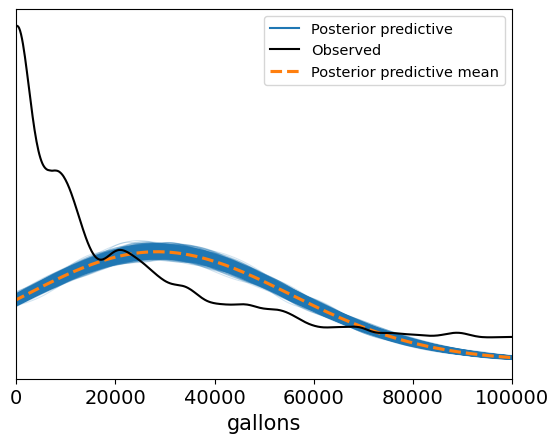

In [62]:
model_below_1e5_no_zero.predict(idata_below_1e5_no_zero, kind="response")
az.plot_ppc(idata_below_1e5_no_zero).set_xbound(lower=0, upper=1e5)

In [63]:
model_below_1e6_no_zero = bmb.Model("gallons ~ temp_max + temp_min + humidity + precipitation + population + year + month + class + zipcode_str", data=data[(data.gallons < 1e6) & (data.gallons > 0)])
idata_below_1e6_no_zero = model_below_1e6_no_zero.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, temp_max, temp_min, humidity, precipitation, population, year, month, class, zipcode_str]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


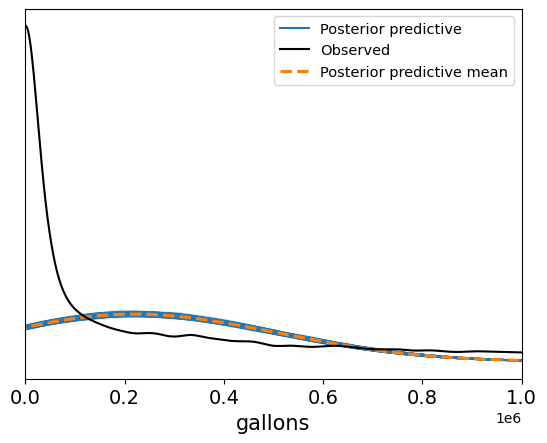

In [64]:
model_below_1e6_no_zero.predict(idata_below_1e6_no_zero, kind="response")
az.plot_ppc(idata_below_1e6_no_zero).set_xbound(lower=0, upper=1e6)

/opt/homebrew/anaconda3/envs/data-science-fundamentals/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: temp_max, zipcode
Default computed for unspecified variable: class, humidity, month, population, precipitation, temp_min, year, zipcode_str


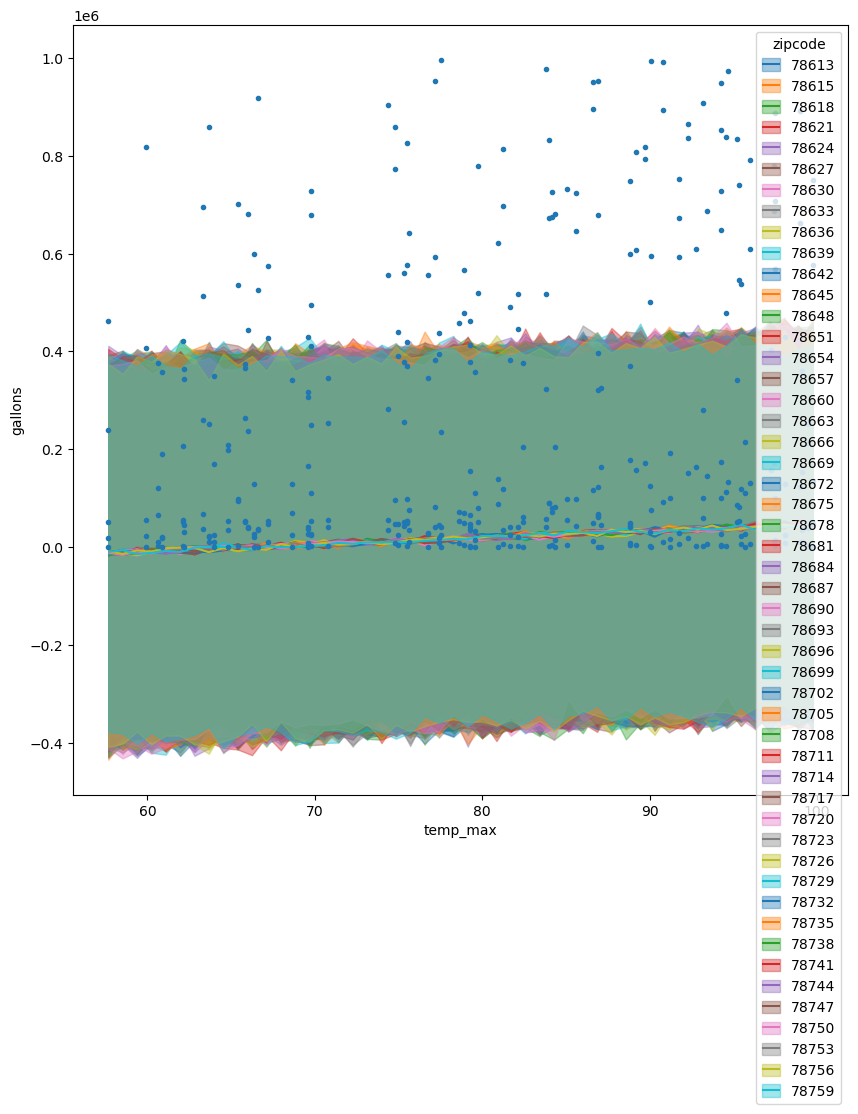

In [65]:
_, ax = bmb.interpret.plot_predictions(model_below_1e6_no_zero, idata_below_1e6_no_zero, ["temp_max", "zipcode"],
                                       pps = True,
                                       fig_kwargs={"figsize": (10, 10)})
zip = list(set(data['zipcode_str']))[0]
ax[0].plot(data["temp_max"][(data.gallons < 1e6) & (data.zipcode_str == zip)], data["gallons"][(data.gallons < 1e6) & (data.zipcode_str == zip)], ".")
# ax[0].plot(data["temp_max"], data["gallons"], "C2.")

/opt/homebrew/anaconda3/envs/data-science-fundamentals/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: temp_max, zipcode
Default computed for unspecified variable: class, humidity, month, population, precipitation, temp_min, year, zipcode_str


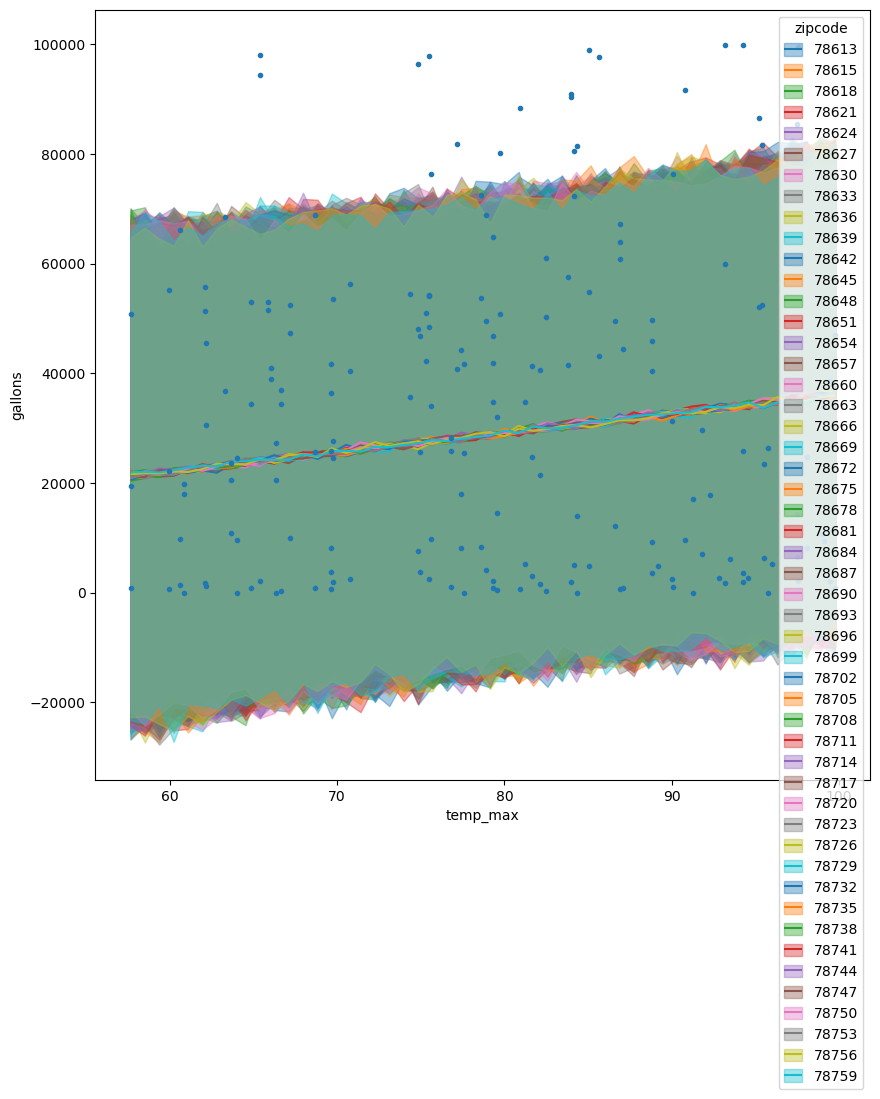

In [66]:
_, ax = bmb.interpret.plot_predictions(model_below_1e5_no_zero, idata_below_1e5_no_zero, ["temp_max", "zipcode"],
                                       pps = True,
                                       fig_kwargs={"figsize": (10, 10)})
zip = list(set(data['zipcode_str']))[0]
ax[0].plot(data["temp_max"][(data.gallons < 1e5) & (data.zipcode_str == zip)], data["gallons"][(data.gallons < 1e5) & (data.zipcode_str == zip)], ".")
# ax[0].plot(data["temp_max"], data["gallons"], "C2.")

### Class Split
1e5 did a little better taking out the zeroes, but 1e6 not so much. Again, I can't believe I didn't think of this first, but I literally have a class variable. I'm going to try splitting by that, and just look at the residential classes.

In [77]:
# why limit by gallons when we literally have class...
residential_data = data[(data['class'] == 'Residential') | (data['class'] == 'Multi-Family') | (data['class'] == 'Irrigation - Residential') | (data['class'] == 'Irrigation - Multi-Family') & (data.gallons > 0)]

model_residential = bmb.Model("gallons ~ temp_max + temp_min + humidity + precipitation + population + year + month + class + zipcode_str", data=residential_data)
idata_residential = model_residential.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, temp_max, temp_min, humidity, precipitation, population, year, month, class, zipcode_str]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


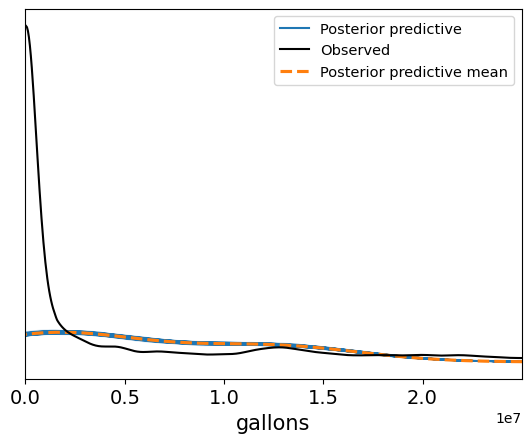

In [82]:
model_residential.predict(idata_residential, kind="response")
az.plot_ppc(idata_residential).set_xbound(lower=0, upper=max(residential_data.gallons))

### PPC
Still not great, but I just realized that I don't actually need the PPC to be that great. I can still get some information out of this, without making a perfectly functional model. Since the residential data should be a little bit nicer to work with, I'm now going to try to do some analysis. First, temp_max vs gallons, separated by class and zipcode. The key things I'm interested in with the categories is how the slopes and/or intercepts vary across zipcode or class.

/opt/homebrew/anaconda3/envs/data-science-fundamentals/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: temp_max, zipcode_str, class
Default computed for unspecified variable: humidity, month, population, precipitation, temp_min, year


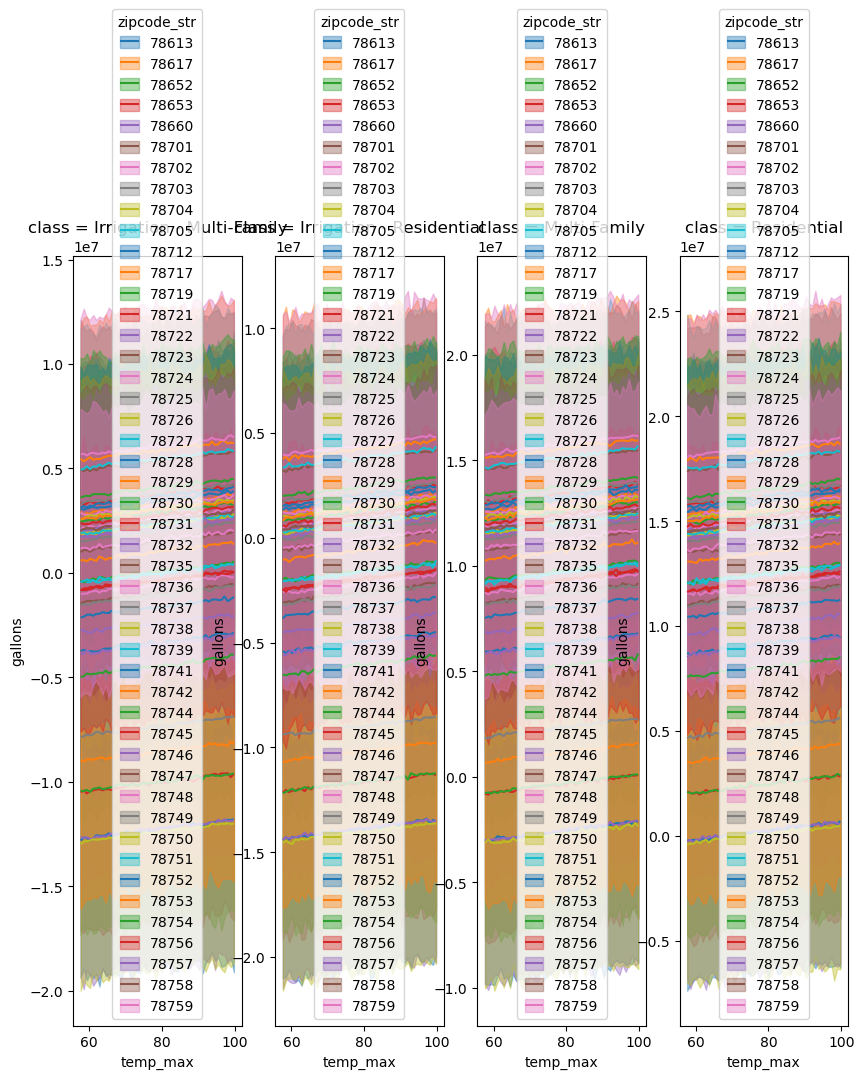

In [85]:
_, ax = bmb.interpret.plot_predictions(model_residential, idata_residential, ["temp_max", "zipcode_str", "class"],
                                       pps = True,
                                       fig_kwargs={"figsize": (10, 10)})

#### `temp_max` vs `gallons`
Now this is interesting. The intercepts for the irrigation classes are lower than non-irrigation, which makes sense. There are definitely zip codes that have higher intercepts (use more water in general), but the slopes are identical across both categories. It trends up, which is precisely what I would expect. I'm curious if I can extract that slope though. After a little research, I found this:

In [145]:
bmb.interpret.slopes(model_residential, idata_residential, wrt="temp_max").estimate

/opt/homebrew/anaconda3/envs/data-science-fundamentals/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for wrt variable: temp_max


0        21201.943724
1        21201.943723
2        21201.943723
3        21201.943723
4        21201.943724
             ...     
11103    21201.943724
11104    21201.943724
11105    21201.943724
11106    21201.943724
11107    21201.943724
Name: estimate, Length: 11108, dtype: float64

#### `temp_max` vs `gallons` Slope
There we go! Looks like for about every degree (Fahrenheit) increase in temperature, pretty much all zipcodes and classes increase water consumption by about 21201 gallons. Let's look at population next. This should be pretty direct.

/opt/homebrew/anaconda3/envs/data-science-fundamentals/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: population, zipcode_str, class
Default computed for unspecified variable: humidity, month, precipitation, temp_max, temp_min, year


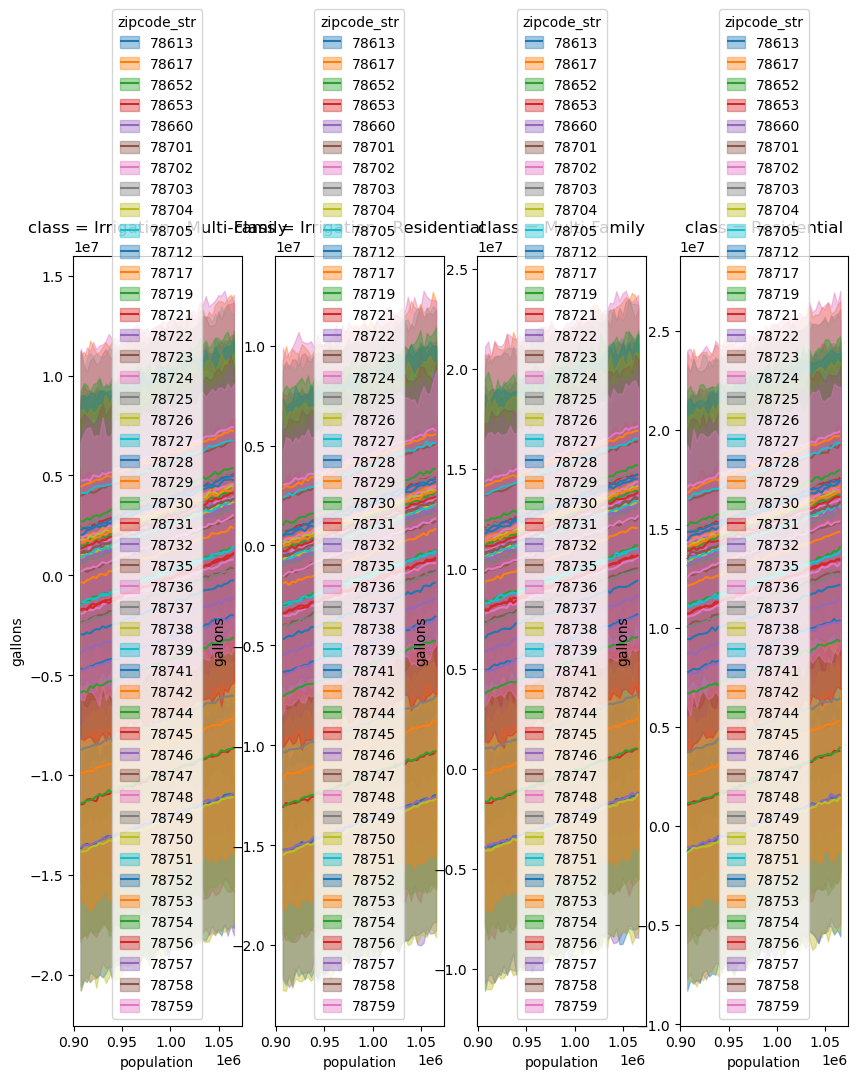

In [139]:
_, ax = bmb.interpret.plot_predictions(model_residential, idata_residential, ["population", "zipcode_str", "class"],
                                       pps = True,
                                       fig_kwargs={"figsize": (10, 10)})

In [146]:
bmb.interpret.slopes(model_residential, idata_residential, wrt="population").estimate

/opt/homebrew/anaconda3/envs/data-science-fundamentals/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for wrt variable: population


0        17.417125
1        17.417125
2        17.417125
3        17.417125
4        17.417125
           ...    
11103    17.417146
11104    17.417146
11105    17.417146
11106    17.417146
11107    17.417146
Name: estimate, Length: 11108, dtype: float64

### `population` vs `gallons`
As expected, an increase in population shows a pretty direct increase in water consumption. Makes sense. The slope is actually very interesting to me, because that means that while some people use more water (some zipcodes have higher intercepts), in general each person adds about 17 gallons. On to precipitation. I'm actually not sure what to expect here, though maybe a slight downward trend in irrigation consumption.

/opt/homebrew/anaconda3/envs/data-science-fundamentals/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: precipitation, zipcode_str, class
Default computed for unspecified variable: humidity, month, population, temp_max, temp_min, year


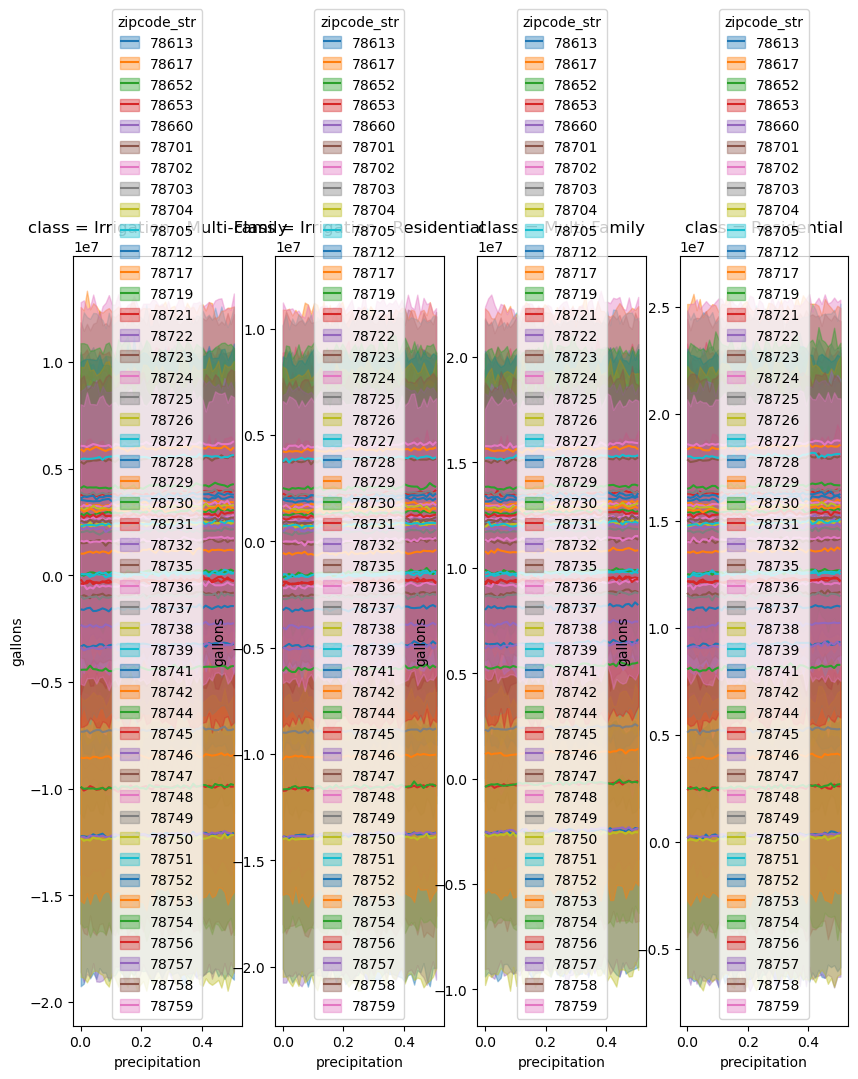

In [140]:
_, ax = bmb.interpret.plot_predictions(model_residential, idata_residential, ["precipitation", "zipcode_str", "class"],
                                       pps = True,
                                       fig_kwargs={"figsize": (10, 10)})

### `precipitation` vs `gallons`
Interestingly flat. What this tells us though is that rainfall actually doesn't have a huge impact on water consumption. This may mean there's some room for water conservation in the irrigation classes. Let's look at year next, see what the trend is over time.

/opt/homebrew/anaconda3/envs/data-science-fundamentals/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: year, zipcode_str, class
Default computed for unspecified variable: humidity, month, population, precipitation, temp_max, temp_min


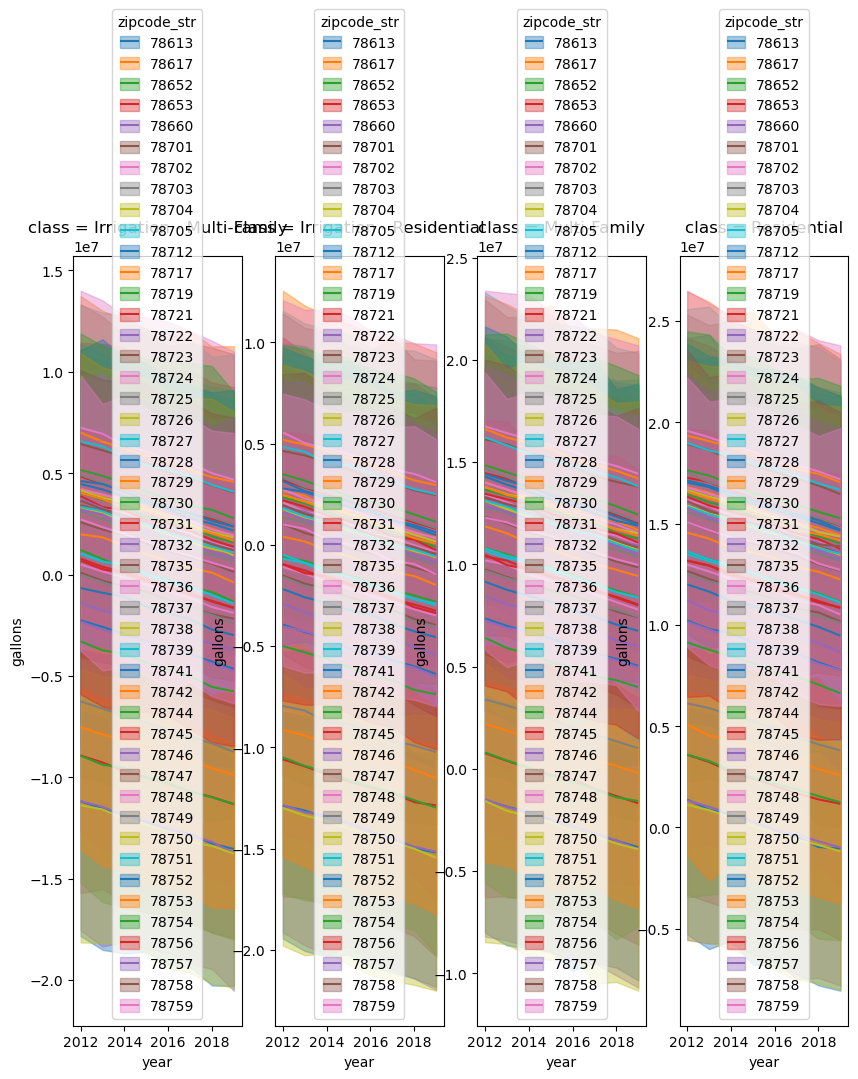

In [141]:
_, ax = bmb.interpret.plot_predictions(model_residential, idata_residential, ["year", "zipcode_str", "class"],
                                       pps = True,
                                       fig_kwargs={"figsize": (10, 10)})

In [148]:
bmb.interpret.slopes(model_residential, idata_residential, wrt="year").estimate

/opt/homebrew/anaconda3/envs/data-science-fundamentals/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for wrt variable: year


0       -342328.348171
1       -342328.348171
2       -342328.348171
3       -342328.348171
4       -342328.348171
             ...      
11103   -342328.348183
11104   -342328.348183
11105   -342328.348183
11106   -342328.348183
11107   -342328.348183
Name: estimate, Length: 11108, dtype: float64

### `year` vs `gallons`
This is actually very interesting. It looks like residential water consumption has actually gone down, which is definitely not what I would expect. I'm going to take a look at the data to see if there's anything weird going on.

In [152]:
{y: sum(residential_data.gallons[residential_data.year == y]) for y in sorted(set(residential_data.year))}

{2012: 7160573300.0,
 2013: 7307312800.0,
 2014: 7347655900.0,
 2015: 7335001700.0,
 2016: 7518184900.0,
 2017: 7656164700.0,
 2018: 7502209400.0,
 2019: 5447171000.0}

#### 2019
There we go. I forgot that the 2019 data isn't entirely complete. I'm going to try taking that out and see if the trend is still downward.

In [153]:
final_data = residential_data[residential_data.year != 2019]

model_final = bmb.Model("gallons ~ temp_max + temp_min + humidity + precipitation + population + year + month + class + zipcode_str", data=final_data)
idata_final = model_final.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, temp_max, temp_min, humidity, precipitation, population, year, month, class, zipcode_str]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 147 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


/opt/homebrew/anaconda3/envs/data-science-fundamentals/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: year, zipcode_str, class
Default computed for unspecified variable: humidity, month, population, precipitation, temp_max, temp_min


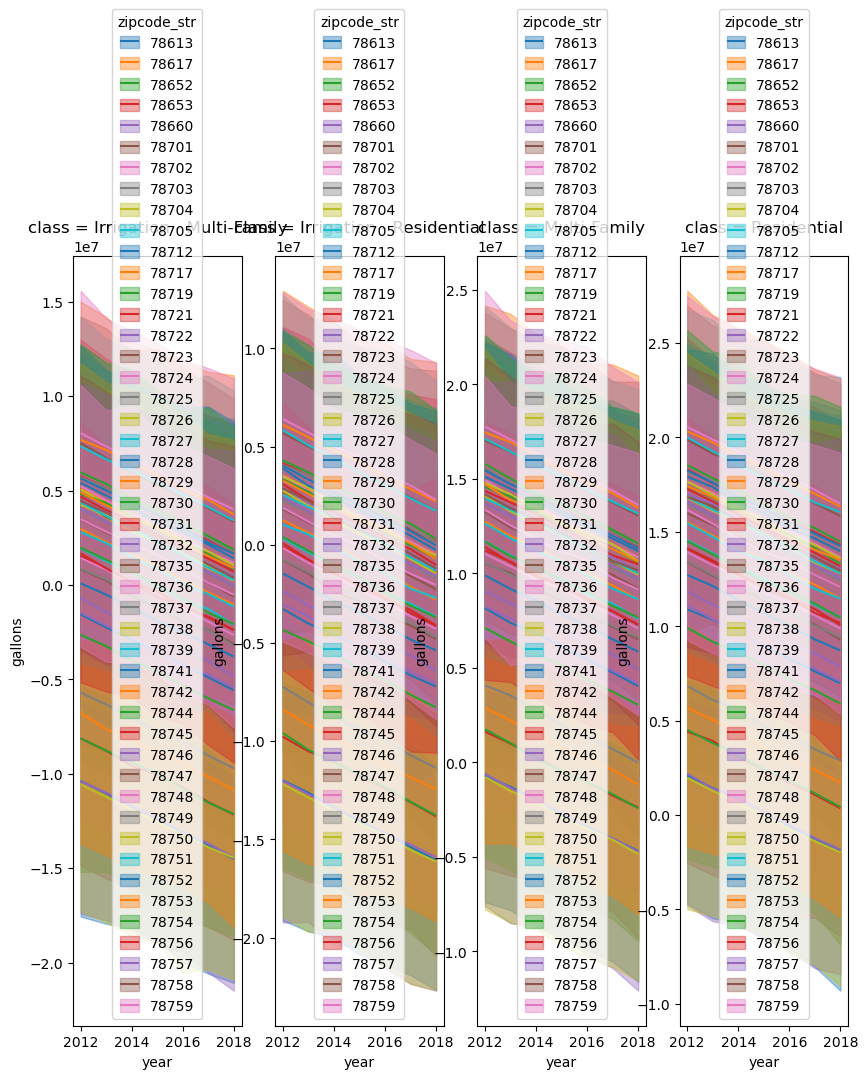

In [154]:
_, ax = bmb.interpret.plot_predictions(model_final, idata_final, ["year", "zipcode_str", "class"],
                                       pps = True,
                                       fig_kwargs={"figsize": (10, 10)})

In [156]:
bmb.interpret.slopes(model_residential, idata_residential, wrt="year").estimate

/opt/homebrew/anaconda3/envs/data-science-fundamentals/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for wrt variable: year


0       -342328.348171
1       -342328.348171
2       -342328.348171
3       -342328.348171
4       -342328.348171
             ...      
11103   -342328.348183
11104   -342328.348183
11105   -342328.348183
11106   -342328.348183
11107   -342328.348183
Name: estimate, Length: 11108, dtype: float64

### `year` vs `gallons`
Interesting. Still very significantly downwards. I'm not entirely sure what's going on here, but unfortunately I don't have the time to dig into it. That would definitely be something to look at given more time. The final thing I want to check is month, see how that impacts water consumption.

/opt/homebrew/anaconda3/envs/data-science-fundamentals/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: month, zipcode_str, class
Default computed for unspecified variable: humidity, population, precipitation, temp_max, temp_min, year


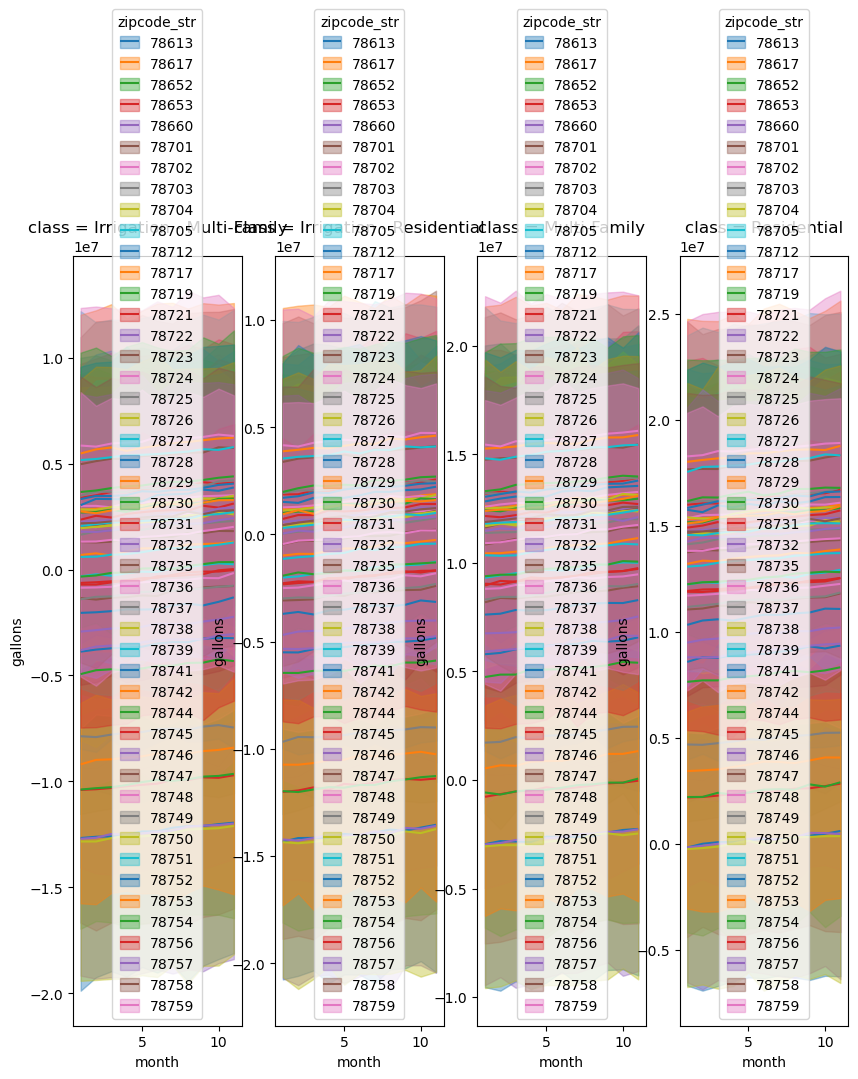

In [157]:
_, ax = bmb.interpret.plot_predictions(model_final, idata_final, ["month", "zipcode_str", "class"],
                                       pps = True,
                                       fig_kwargs={"figsize": (10, 10)})

In [158]:
bmb.interpret.slopes(model_final, idata_final, wrt="month").estimate

/opt/homebrew/anaconda3/envs/data-science-fundamentals/lib/python3.12/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for wrt variable: month


0        67795.552543
1        67795.552543
2        67795.552543
3        67795.552543
4        67795.552543
             ...     
10020    67795.552543
10021    67795.552543
10022    67795.552543
10023    67795.552543
10024    67795.552543
Name: estimate, Length: 10025, dtype: float64

### `month` vs `gallons`
Interestingly, this give us a slight upward trend. I think I have an idea of what's going on though. What we would expect is for it to start low in January, go high over the summer, then lower again in the winter. However, since this is only a GLM rather than a spline, it can only give a line. This is why we see a very slight upward trend. Again, given more time, this could be adjusted for, but this is good enough for now.

## Conclusion
I'm actually pretty happy with this. I was able to get some pretty good insights into the data, and I think I've got a good idea of what's going on. I think the biggest thing I would want to look at is the downward trend in water consumption over time. I also think that the model could be improved by adding some splines, but that's something for another day. Here's a summary of the interactions I found:

- `temp_max`: For every degree increase in temperature, water consumption increases by 21201 gallons.
- `population`: For every person, water consumption increases by 17 gallons.
- `precipitation`: Precipitation has no significant impact on water consumption.
- `year`: Water consumption appears to decrease over time when broken into zipcode and class
- `month`: Water consumption increases over the year, but this is likely due to the limitations of the model.